In [53]:
import numpy as np
import pandas as pd
import pickle
from tqdm.notebook import tqdm
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import sys
sys.path.append('../utils')
from utils import load_processed_data

## Baseline Models
- Selects a few stations from the preprocessed Fwy 405 N data
- Uses very basic prediction methods (e.g. using mean values)
- Considers MAE and RMSE on the test data
- Allows us to see baseline accuracy metrics

Note: must run the notebook `/preprocessing/preprocess.ipynb` to get the required data, or import processed data from Google Drive explained on main README.

In [54]:
station_meta = pd.read_csv('../data/processed/fwy_405_n_ds/meta.csv')
station_meta.head()

,ID,Fwy,Dir,District,County,City,State_PM,Abs_PM,Latitude,Longitude,Length,Type,Lanes,Name
0,771826,405,N,7,37,43000.0,.11,24.058,33.787054,-118.094505,0.303,ML,4,N. OF 605
1,717696,405,N,7,37,43000.0,.6,24.548,33.791829,-118.100867,0.495,ML,4,STUDEBAKER
2,718219,405,N,7,37,43000.0,1.1,25.048,33.796718,-118.107431,0.565,ML,4,PALO VERDE
3,717701,405,N,7,37,43000.0,1.73,25.678,33.802431,-118.115997,0.675,ML,4,WOODRUFF
4,717703,405,N,7,37,43000.0,2.45,26.398,33.802865,-118.128314,0.505,ML,4,BELLFLOWER 2


In [55]:
_, _, station_data = load_processed_data('../data/processed/fwy_405_n_ds')

station_data.head()

,771826,717696,718219,717701,717703,718227,717706,717709,716632,771845,...,767351,717819,717823,767367,717825,717827,771808,771767,772011,772024
2021-01-01 00:00:00,69.2,68.6,69.9,70.8,68.7,70.5,72.6,72.2,71.4,69.2,...,64.9,68.7,68.1,67.7,68.1,67.8,64.9,71.8,69.3,66.8
2021-01-01 00:05:00,70.4,68.2,67.9,69.4,66.9,70.6,72.2,73.7,71.5,69.4,...,64.9,69.6,68.7,68.4,69.4,68.4,63.8,68.8,69.4,65.0
2021-01-01 00:10:00,70.1,69.3,69.4,70.5,67.4,70.7,70.5,73.3,71.6,70.0,...,65.2,69.2,68.2,67.8,68.7,67.5,65.0,67.5,69.8,67.1
2021-01-01 00:15:00,69.9,68.7,69.1,69.9,70.5,70.4,71.9,75.4,71.6,69.8,...,64.7,69.4,68.4,68.3,69.9,68.8,67.0,72.8,69.0,66.3
2021-01-01 00:20:00,70.3,69.5,68.9,70.6,59.8,71.0,72.5,74.5,71.9,70.8,...,65.0,70.3,68.9,68.7,69.9,68.1,69.8,72.6,69.1,65.8


### Construct Model

In [56]:
class baseline_mod:
    def __init__(self, pred_method='mean'):
        self.train_data = None
        if pred_method in ['mean', 'mean_tod']: # tod=time of day
            self.pred_method = pred_method
        else:
            raise Exception("Prediction method must be 'mean' or 'mean_tod'!")
    
    def fit(self, train_data):
        self.train_data = train_data
    
    def predict(self, test_data):
        if self.train_data is None: 
            raise Exception('You must fit before predicting!')
        
        if self.pred_method == 'mean_tod':
            df = self.train_data.to_frame().reset_index().rename(columns={'index': 'Time', self.train_data.name: 'Speed'})
            df['H'] = [x.hour for x in df['Time']]
            df['M'] = [x.minute for x in df['Time']]
            dm = df.groupby(['H', 'M']).mean()['Speed']

            preds = [dm[x.hour][x.minute] for x in test_data.index] 
            return np.array(preds)
        else:
            mean = np.mean(train_data.values)
            return np.array([mean for x in range(test_data.shape[0])])

### Train Test Split

In [57]:
# good example stations to try
#   717711  (difficult)
#   716659  (many random outliers)
#   761455  (periodic)
#   772455  (very periodic)

# select a station number to use
STATION = 772455

# use may, june as train data and july as test data
df = station_data[STATION]
train_data = df[df.index < pd.to_datetime('2021-07-01')]
test_data = df[df.index >= pd.to_datetime('2021-07-01')]

<AxesSubplot:>

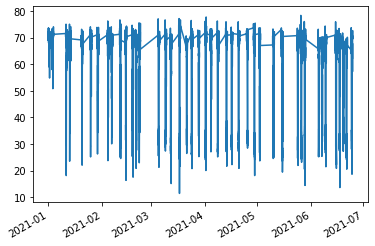

In [58]:
train_data.plot()

### Mean Fill
Simply predict the mean value

In [36]:
baseline = baseline_mod(pred_method='mean')
baseline.fit(train_data)
preds = baseline.predict(test_data)

MAE:  17.327
RMSE: 18.982


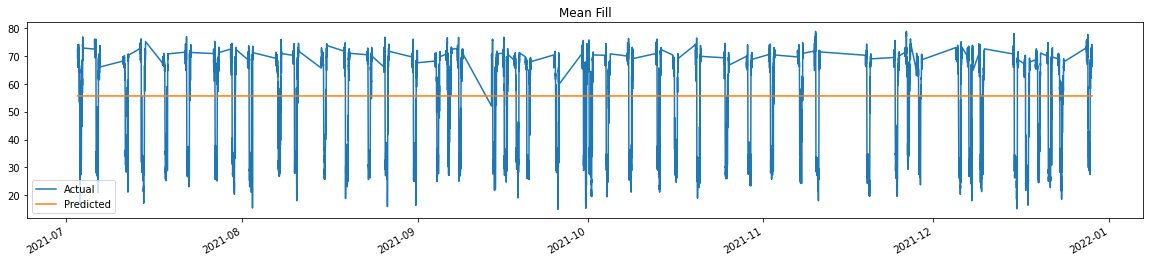

In [37]:
# results
print('MAE:  %.3f' % mean_absolute_error(test_data.values, preds))
print('RMSE: %.3f' % mean_squared_error(test_data.values, preds, squared=False))

p = pd.DataFrame(
    {'Actual': test_data.values, 'Predicted': preds}, 
    index=test_data.index 
).plot(figsize=(20,4), title='Mean Fill')

### Daily Mean
Predict using the mean value based on the time of day

In [48]:
from time import time

In [49]:
baseline = baseline_mod(pred_method='mean_tod')
start = time()
baseline.fit(train_data)
end = time()
train_time = end - start
preds = baseline.predict(test_data)

In [51]:
# with open('./trained/baseline/baseline.dat', 'wb') as f:
#     pickle.dump(baseline, f)

MAE:  8.004
RMSE: 11.499


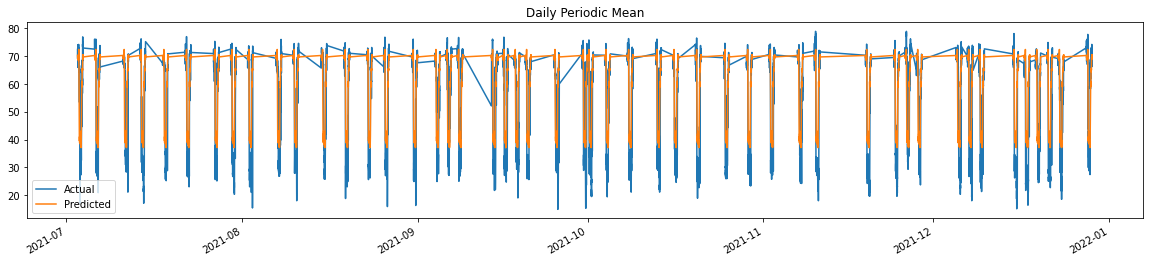

In [39]:
# results
print('MAE:  %.3f' % mean_absolute_error(test_data.values, preds))
print('RMSE: %.3f' % mean_squared_error(test_data.values, preds, squared=False))

p = pd.DataFrame(
    {'Actual': test_data.values, 'Predicted': preds}, 
    index=test_data.index
).plot(figsize=(20,4), title='Daily Periodic Mean')

In [52]:
# with open('./trained/baseline/metrics_baseline.dat', 'wb') as f:
#     metrics = {'mse': mean_squared_error(test_data.values, preds), 'rmse': mean_squared_error(test_data.values, preds, squared=False), 'r2': r2_score(test_data.values, preds), 'train_time': train_time}
#     pickle.dump(metrics, f)